In [1]:
from src.ocsmm.OneClassSMMClassifier import OneClassSMMClassifier
import numpy as np
import matplotlib.pyplot as plt

In [2]:

def generate_compact_dataset():
    # Set the mean for normal groups (same for all normal groups)
    np.random.seed(54) 
    mean_normal = np.array([0, 0])

    base_cov_normal =  [[1.1, 1], [1, 1.1]]

    angle_rad = np.radians(90)

    # Create the rotation matrix for 2D
    rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                [np.sin(angle_rad), np.cos(angle_rad)]])

    # Set the mean for outlier groups (far from the normal groups)
    mean_outlier = np.array([5, 10])

    # Covariance matrix for outliers (wider spread)
    cov_matrix_rot = rotation_matrix @ base_cov_normal @ rotation_matrix.T

    # Generate 18 normal groups with different variances
    normal_groups = []
    for i in range(47):
        data_normal = np.random.multivariate_normal(mean_normal, base_cov_normal, 20)
        normal_groups.append((data_normal))

    # Generate 2 outlier groups with a different covariance (wider spread)
    outlier_group_1 = np.random.multivariate_normal(mean_normal, cov_matrix_rot, 20)
    outlier_group_2 = np.random.multivariate_normal(mean_normal+[5,0],base_cov_normal , 20)
    outlier_group_3 = np.random.multivariate_normal(mean_normal+[5, 0], cov_matrix_rot, 20)

    # Combine all groups
    all_groups = normal_groups + [(outlier_group_1), (outlier_group_2), (outlier_group_3)]

    return all_groups

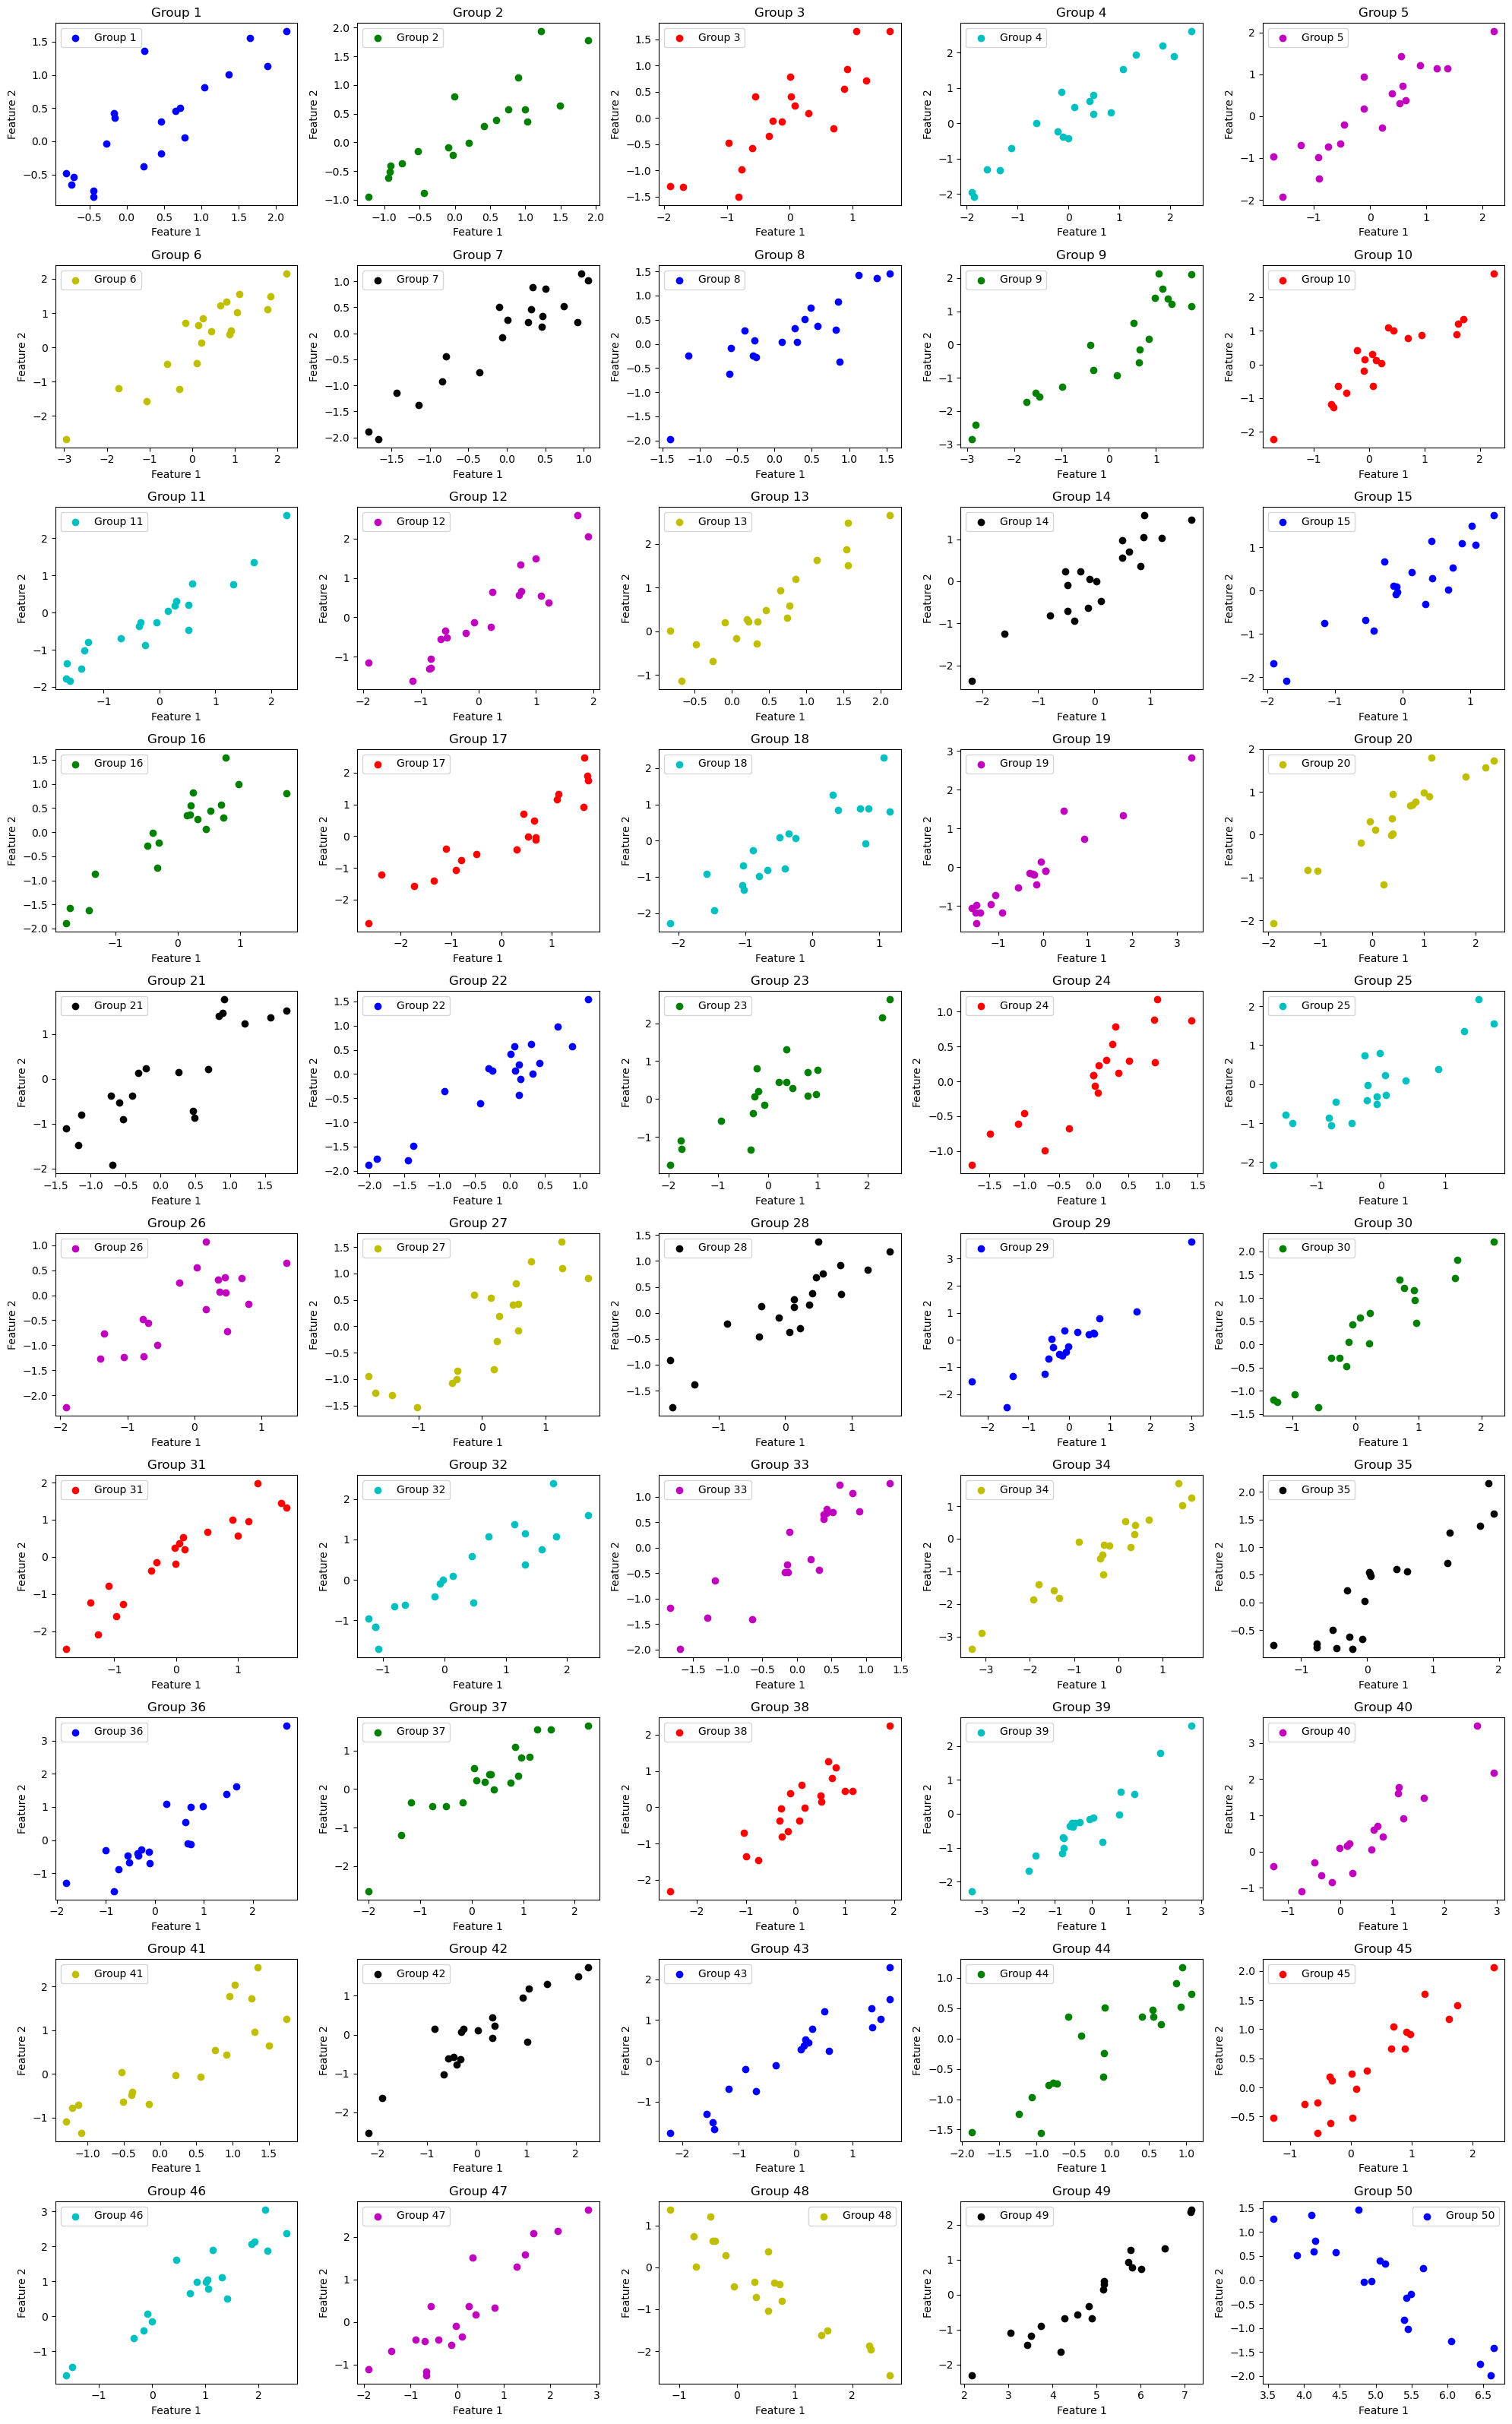

In [3]:
def plot_all_groups_subplots(groups):
    # Create a figure with 8 rows and 5 columns (to fit 40 subplots)
    fig, axes = plt.subplots(10, 5, figsize=(20, 32))  # Adjust figure size for clarity

    # Flatten axes array to easily index it
    axes = axes.flatten()

    # Different colors for each group
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] * 8  # Repeat colors for 40 groups

    for idx, (group, ax) in enumerate(zip(groups, axes)):
        ax.scatter(group[:, 0], group[:, 1], color=colors[idx], label=f"Group {idx + 1}")
        ax.set_title(f"Group {idx + 1}")
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.legend()

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.savefig("dataset.pdf")  # Save figure before showing
    plt.show()  # Display the plots

# Generate the dataset
datasets = generate_compact_dataset()

# Plot all groups on different subplots
plot_all_groups_subplots(datasets)

In [4]:
datasets

[array([[ 2.13966995,  1.65623251],
        [ 0.22228996, -0.38329789],
        [-0.80560169, -0.4776208 ],
        [ 1.88193968,  1.13266928],
        [-0.44594058, -0.74891037],
        [-0.73577311, -0.65280182],
        [ 1.36865977,  1.0021455 ],
        [ 1.04410612,  0.80744709],
        [ 0.46405674,  0.30252598],
        [ 0.23924349,  1.36106429],
        [ 1.65397976,  1.55037025],
        [-0.16156295,  0.35497456],
        [-0.43992714, -0.84004502],
        [-0.17418093,  0.42562081],
        [ 0.781422  ,  0.05077234],
        [ 0.46627443, -0.18710754],
        [ 0.71804034,  0.50623773],
        [ 0.65456849,  0.45301362],
        [-0.26799777, -0.02958093],
        [-0.70776336, -0.54187734]]),
 array([[-0.91531912, -0.39995102],
        [-0.51896551, -0.15369865],
        [-0.02896497, -0.21744821],
        [-0.00674962,  0.79474821],
        [-1.22667749, -0.95185128],
        [ 0.59118961,  0.39350912],
        [-0.94458499, -0.61913725],
        [ 1.49685797,  0.6

In [5]:
classifier = OneClassSMMClassifier(nu=0.1)
classifier.fit(datasets)

In [6]:
decision, y_pred = classifier.predict(datasets)

In [7]:
decision

array([ 0.11948391,  0.12272271,  0.12733166,  0.12251337,  0.12800304,
        0.09838092,  0.11132605,  0.11002246,  0.088909  ,  0.12765245,
        0.11216194,  0.1299455 ,  0.10509769,  0.12729566,  0.12051666,
        0.11245941,  0.11812187,  0.10509768,  0.07095477,  0.10509773,
        0.12646574,  0.10593333,  0.12188945,  0.11012867,  0.11808743,
        0.10923849,  0.12732142,  0.1133028 ,  0.10509759,  0.12669301,
        0.12580111,  0.12580871,  0.11915529,  0.11802932,  0.12525193,
        0.12565569,  0.11346492,  0.12557741,  0.08938298,  0.12067874,
        0.12082377,  0.13048203,  0.11756081,  0.11856052,  0.1157107 ,
        0.04902538,  0.12366543, -0.00066521, -0.40674353, -0.40965537])

In [8]:
y_pred

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.])

In [9]:
outlier_indices = [i for i, value in enumerate(y_pred) if value == -1]
outlier_indices

[47, 48, 49]

In [10]:
from src.explanation_algorithms.OCSMMSHAP import OCSMMSHAP
ocsmm_shap = OCSMMSHAP(X=datasets, classifier=classifier, decision=decision)
ocsmm_shap.fit_ocsmmshap(X=datasets, num_coalitions=2**datasets[0].shape[1])

c:\Users\swath\Documents\CISPA\OCSVM-SHAP\src\utils\shapley_procedure\coalitions.py:18: RuntimeWarning: divide by zero encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
c:\Users\swath\Documents\CISPA\OCSVM-SHAP\src\utils\shapley_procedure\coalitions.py:18: RuntimeWarning: invalid value encountered in cast
  set_to_1 = np.floor(np.log2(rest)).astype(int)
c:\Users\swath\Documents\CISPA\OCSVM-SHAP\src\utils\shapley_procedure\coalitions.py:18: RuntimeWarning: invalid value encountered in log2
  set_to_1 = np.floor(np.log2(rest)).astype(int)
100%|██████████| 3/3 [00:00<00:00, 191.88it/s]


In [11]:
shapley_values = ocsmm_shap.return_deterministic_shapley_values()

The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3618.)


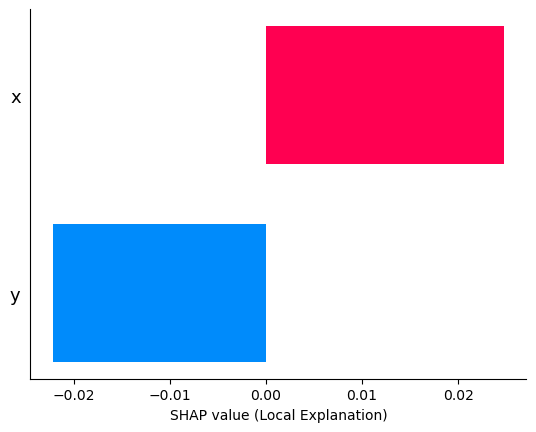

In [13]:
from src.utils.visualisation.deterministic_values import global_bar_plot, bar_plot
bar_plot(shapley_values.T[47], feature_names=['x', 'y'])

Group 17 has tilted covariance and no shift in the mean, the prediction is an outlier because of the interaction of both the x and y values and none of them is dominant.

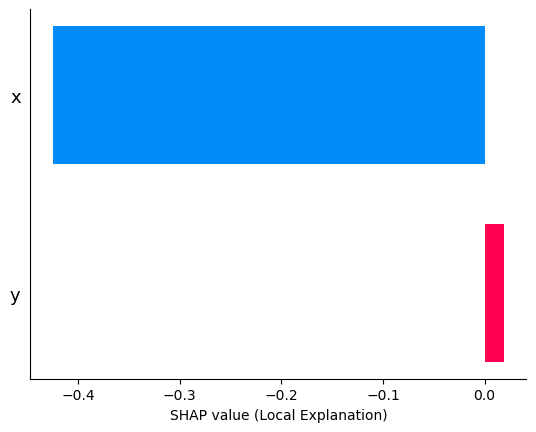

In [14]:
bar_plot(shapley_values.T[48], feature_names=['x', 'y'])

 Group 18 has its mean moved by 5 points to the right on the x axis. The prediction of this point being an outleir is mainly because of the shift in the x axix. This is shown by the high shapley value for the feature x


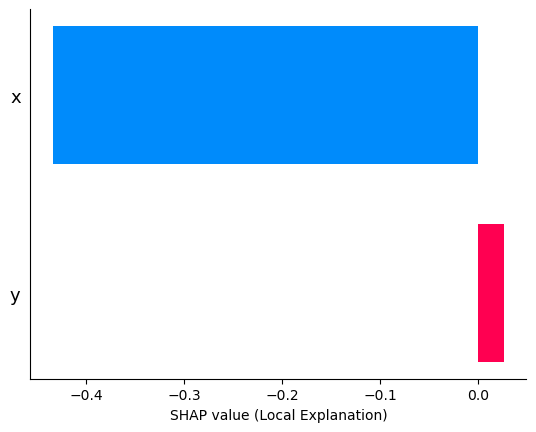

In [15]:
bar_plot(shapley_values.T[49], feature_names=['x', 'y'])

Group 20 (index 19) is not only rotated by 90 degrees it also has its mean shifted by 5 points in the x direction. This shift is contributing more than the tilt which is contributing equally for both features.  So, the feature x is identified as the most influential featrue. 

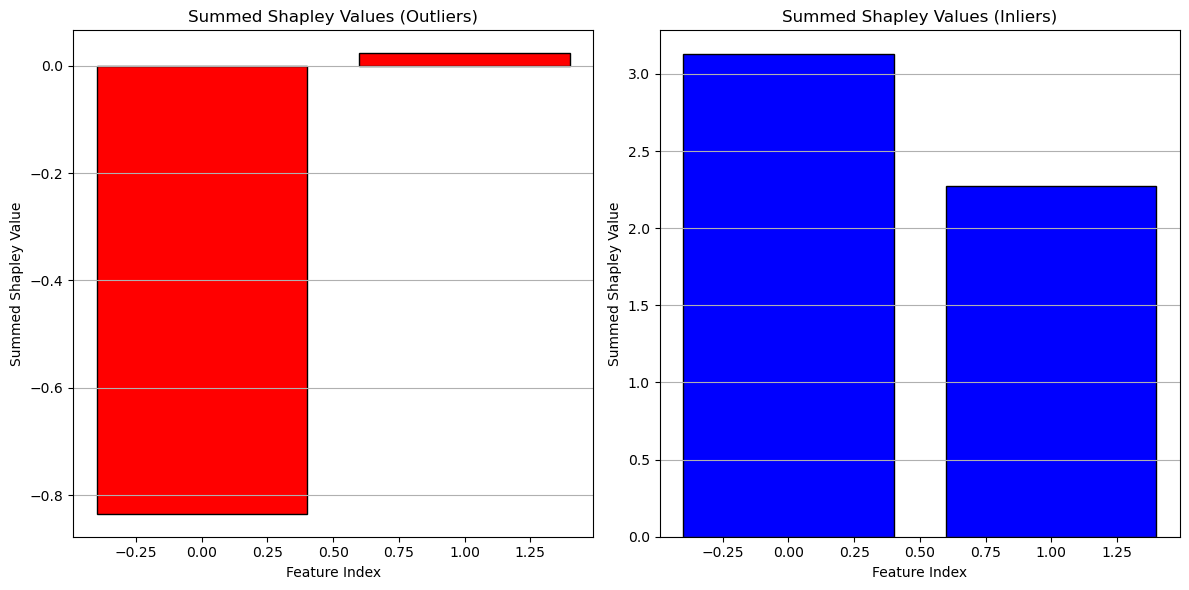

In [16]:
inlier_indices = [i for i in range(shapley_values.shape[1]) if i not in outlier_indices]

summed_outlier_shapley = shapley_values[:, outlier_indices].sum(dim=1).numpy()
summed_inlier_shapley = shapley_values[:, inlier_indices].sum(dim=1).numpy()

# Plot histogram
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Outlier Shapley Values
ax[0].bar(range(len(summed_outlier_shapley)), summed_outlier_shapley, color='red', edgecolor='black')
ax[0].set_title('Summed Shapley Values (Outliers)')
ax[0].set_xlabel('Feature Index')
ax[0].set_ylabel('Summed Shapley Value')
ax[0].grid(True, axis='y')

# Inlier Shapley Values
ax[1].bar(range(len(summed_inlier_shapley)), summed_inlier_shapley, color='blue', edgecolor='black')
ax[1].set_title('Summed Shapley Values (Inliers)')
ax[1].set_xlabel('Feature Index')
ax[1].set_ylabel('Summed Shapley Value')
ax[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

The outliers are moving the decision towards the negative direction, hence their influence is negative. The shifting of the mean is on the x axis and hence feature x has higher contribution

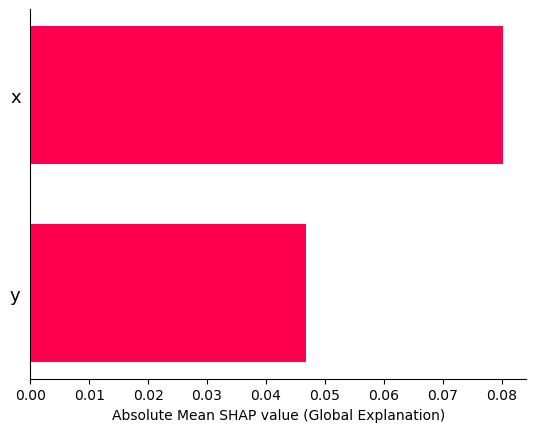

In [17]:
# global importance measure
mean_abs_shap_values = np.abs(shapley_values.T).mean(axis=0)  

# Call bar_plot for global explanation
global_bar_plot(mean_abs_shap_values, feature_names=['x', 'y'])

Accumulated SHAP values for all outliers ( Mean SHAP among outliers )

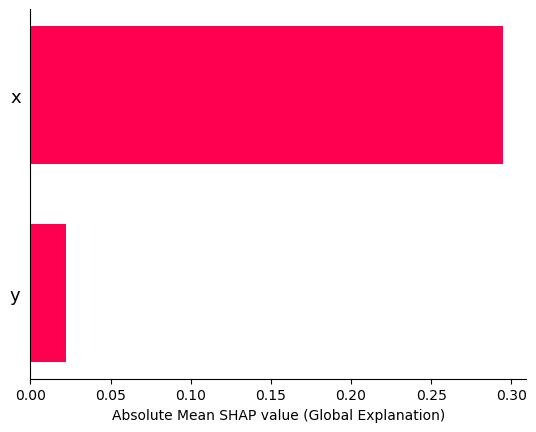

In [ ]:
selected_shap_values = shapley_values[:,outlier_indices]
mean_abs_shap_values_outlier_group = np.abs(selected_shap_values).mean(axis=1) 
global_bar_plot(mean_abs_shap_values_outlier_group, feature_names=['x', 'y'])